<a href="https://colab.research.google.com/github/massirism/Deep-Learning/blob/main/Deep_Learning_Miguel_Massiris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Clone the repository
!git clone https://github.com/massirism/Deep-Learning.git

# Navigate to the "Rome Weather" folder
%cd Deep-Learning/Rome\ Weather/

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 266 (delta 1), reused 258 (delta 1), pack-reused 0
Receiving objects: 100% (266/266), 9.74 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Deep-Learning/Rome Weather


In [3]:
path = "/content/Deep-Learning/Rome Weather"
sub_carpetas=os.listdir(path)
if "Deep-Learning" in sub_carpetas:
    sub_carpetas.remove("Deep-Learning")  #Error al cargar el dataset desde github
sub_carpetas

['Foggy', 'Rainy', 'Cloudy', 'Snowy', 'Sunny']

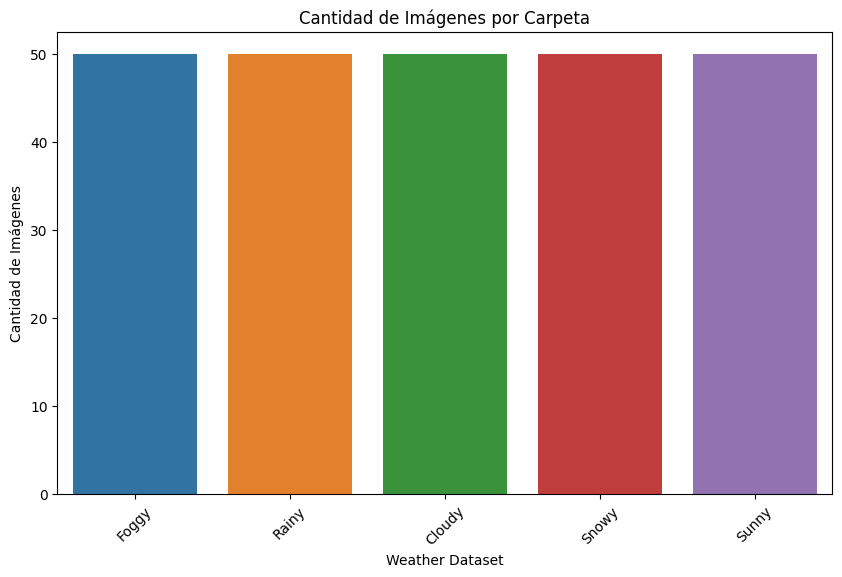

In [4]:
#Crear un diccionario para almacenar la cantidad de imágenes por carpeta
cantidad_imagenes = {}

for carpeta in sub_carpetas:
    ruta_carpeta = os.path.join(path, carpeta)
    cantidad_imagenes[carpeta] = len(os.listdir(ruta_carpeta))

datos = pd.DataFrame.from_dict(cantidad_imagenes, orient='index', columns=['Cantidad'])

plt.figure(figsize=(10, 6))
sns.barplot(x=datos.index, y=datos['Cantidad'])
plt.title('Cantidad de Imágenes por Carpeta')
plt.xlabel('Weather Dataset')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.show()

In [5]:
#Organizar y etiquetar toda el dataset
label = []
image = []

data = {'File_Path': [], 'Labels': []}

for i in os.listdir(path):
    for j in os.listdir(os.path.join(path, i)):
        img_path = os.path.join(path, i, j)
        if os.path.isfile(img_path):
            data['File_Path'].append(img_path)
            data['Labels'].append(i)

df = pd.DataFrame(data)

print(df)

                                             File_Path Labels
0    /content/Deep-Learning/Rome Weather/Foggy/down...  Foggy
1    /content/Deep-Learning/Rome Weather/Foggy/imag...  Foggy
2    /content/Deep-Learning/Rome Weather/Foggy/imag...  Foggy
3    /content/Deep-Learning/Rome Weather/Foggy/imag...  Foggy
4    /content/Deep-Learning/Rome Weather/Foggy/imag...  Foggy
..                                                 ...    ...
245  /content/Deep-Learning/Rome Weather/Sunny/imag...  Sunny
246  /content/Deep-Learning/Rome Weather/Sunny/imag...  Sunny
247  /content/Deep-Learning/Rome Weather/Sunny/imag...  Sunny
248  /content/Deep-Learning/Rome Weather/Sunny/imag...  Sunny
249  /content/Deep-Learning/Rome Weather/Sunny/imag...  Sunny

[250 rows x 2 columns]


In [6]:
num_classes=len(os.listdir(path))

# Funciones con cada paso del entrenamiento del clasificador

## Data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=(100, 100)
batch_size=32
def generacion_de_datos(pre, train, test):
    # Crear generadores de datos para entrenamiento y prueba
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    # Generador de datos para entrenamiento (con aumento de datos)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',  # Columna que contiene las rutas de las imágenes
        y_col='Labels',     # Columna que contiene las etiquetas
        target_size=image_size,  # Tamaño de las imágenes después de redimensionar
        class_mode='categorical',  # Tipo de tarea (clasificación categórica)
        batch_size=batch_size,       # Tamaño del lote
        shuffle=True,        # Mezclar los datos en cada época
        seed=0,
        subset='training',   # Usar una subconjunto de datos de entrenamiento
        rotation_range=35,   # Rango de rotación aleatoria
        zoom_range=0.1,    #Rango de zoom aleatoria
        shear_range=0.1,    # Rango de deformación aleatoria
        horizontal_flip=True,  # Voltear horizontalmente las imágenes
        fill_mode="nearest"   # Cómo llenar los píxeles creados por transformaciones
        )

    # Generador de datos para validación (sin aumento de datos)
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,  # No mezclar los datos de validación
        seed=0,
        subset='validation',  # Usar un subconjunto de datos de validación
        rotation_range=20,
        shear_range=0.4,
        vertical_flip=True,
        fill_mode="nearest"
        )

    # Generador de datos para prueba (sin aumento de datos)
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=image_size,
        color_mode='rgb',  # Modo de color (RGB)
        class_mode='categorical',
        batch_size=batch_size,
        verbose=0,  # No mostrar información de progreso
        shuffle=False)  # No mezclar los datos de prueba

    # Devolver los generadores de datos
    return train_gen, valid_gen, test_gen

## Crea el modelo, agrega capaz necesarias y lo compila

In [8]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

def crear_modelo(nombre_del_modelo):
    # Carga un modelo preentrenado y congela sus capas
    pre_model = nombre_del_modelo(
        input_shape=(100, 100, 3),  # Tamaño de entrada de las imágenes (ancho x alto x canales)
        include_top=False,  # Excluye la capa de clasificación final del modelo preentrenado
        weights='imagenet',  # Carga pesos preentrenados de ImageNet
        pooling='avg')  # Realiza un promedio global sobre las características

    pre_model.trainable = False  # No se entrenarán las capas del modelo preentrenado

    # Conexión de capas para construir el modelo personalizado
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)  # Agrega una capa densa con activación ReLU
    x = Dense(100, activation='relu')(x)  # Agrega otra capa densa con activación ReLU
    outputs = Dense(num_classes, activation='softmax')(x)  # Capa de salida con activación softmax para clasificación

    # Crea el modelo completo
    model = Model(inputs=inputs, outputs=outputs)

    # Compila el modelo con la función de pérdida, optimizador y métricas
    model.compile(
        loss='categorical_crossentropy',  # Función de pérdida para clasificación categórica
        optimizer='Adam',  # Algoritmo de optimización (Adam en este caso)
        metrics=['accuracy'])  # Métrica de precisión para evaluar el rendimiento

    # Configura una lista de devolución de llamada, en este caso EarlyStopping
    my_callbacks = [EarlyStopping(
        monitor='val_loss',  # Monitorear la pérdida en el conjunto de validación
        min_delta=0,  # Umbral mínimo de cambio para considerar como mejora
        patience=2,  # Número de épocas sin mejora antes de detener el entrenamiento
        mode='auto')]  # Modo automático para determinar la dirección de mejora

    return model, my_callbacks  # Devuelve el modelo y las devoluciones de llamada

## Entrenar el modelo y graficar el accuracy y loss de los datos de entrenamiento y validación. Además se calcula la matriz de confusión y muestreos de algunas imagenes.

In [14]:
def graficar(history, test_gen, train_gen, model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])  # Grafica la métrica de entrenamiento (accuracy o loss)
        ax[i].plot(history.history['val_' + met])  # Grafica la métrica de validación correspondiente
        ax[i].set_title('Model {}'.format(met))  # Establece el título del gráfico
        ax[i].set_xlabel('epochs')  # Etiqueta del eje x
        ax[i].set_ylabel(met)  # Etiqueta del eje y
        ax[i].legend(['Train', 'Validation'])  # Leyendas para las líneas de entrenamiento y validación
    return history  # Devuelve el historial de entrenamiento

def evaluar_modelo(test_gen, train_gen, model):
    # Predict Data Test
    pred = model.predict(test_gen)  # Realiza predicciones en el conjunto de prueba
    pred = np.argmax(pred, axis=1)  # Obtiene los índices de las clases predichas
    labels = (train_gen.class_indices)  # Obtiene un diccionario de etiquetas e índices del conjunto de entrenamiento
    labels = dict((v, k) for k, v in labels.items())  # Invierte el diccionario para obtener etiquetas a partir de índices
    pred = [labels[k] for k in pred]  # Convierte los índices predichos en etiquetas reales

    # Classification report
    cm = confusion_matrix(test_df.Labels, pred)  # Calcula la matriz de confusión
    clr = classification_report(test_df.Labels, pred)  # Calcula el informe de clasificación
    print(clr)  # Imprime el informe de clasificación
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
              xticklabels = sub_carpetas, # Puedes reemplazar class_names con las etiquetas de tus clases
              yticklabels = sub_carpetas)
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
    plt.title("Matriz de confusión de la predicción del modelo")
    plt.show()
    #return history  # Devuelve el historial de entrenamiento

##Evaluar el modelo con los datos de testeo.

In [10]:
def resultado_test(test, model_use):
    # Evaluar el modelo en el conjunto de prueba
    results = model_use.evaluate(test, verbose=0)

    # Imprimir los resultados de la evaluación
    print("    Test Loss: {:.5f}".format(results[0]))  # Imprimir la pérdida en el conjunto de prueba
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))  # Imprimir la precisión en el conjunto de prueba

    return results  # Devolver los resultados de la evaluación

# Se realiza el split de los datos en datos de entrenamiento (80%) y datos de testeo (20%)

In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

#Aplico modelos

##Resnet 50

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

Found 160 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
2/2 [==============================] - 3s 702ms/step
              precision    recall  f1-score   support

      Cloudy       0.55      0.86      0.67         7
       Foggy       0.92      1.00      0.96        11
       Rainy       0.71      0.50      0.59        10
       Snowy       0.82      0.82      0.82        11
       Sunny       0.78      0.64      0.70        11

    accuracy                           0.76        50
   macro avg       0.75      0.76      0.75        50
weighted avg       0.77      0.76      0.76        50



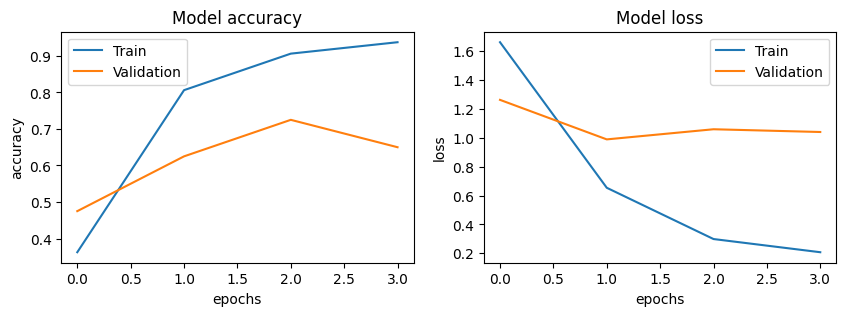

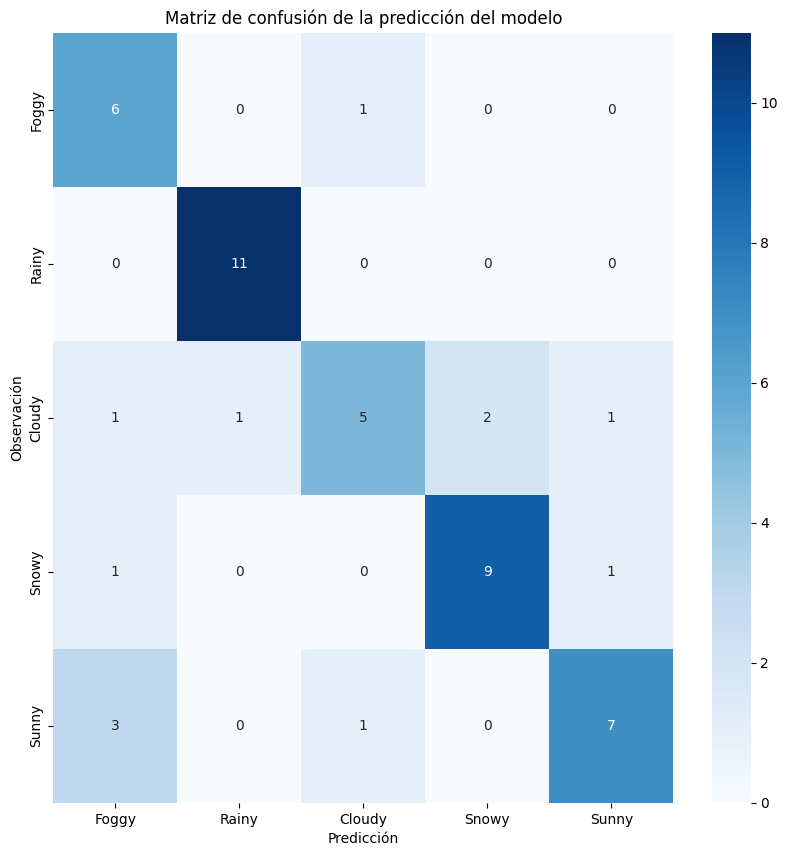

    Test Loss: 0.68214
Test Accuracy: 76.00%


In [15]:
numero_epocas=100

ResNet_pre=preprocess_input

train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = generacion_de_datos(ResNet_pre,train_df,test_df)

ResNet_model, callback=crear_modelo(ResNet50)


history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=numero_epocas,
    callbacks=callback,
    verbose=0
)

history_ResNet= graficar(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

evaluar_modelo(test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = resultado_test(test_gen_ResNet,ResNet_model)

##VGG19

In [16]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

Found 160 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
2/2 [==============================] - 7s 3s/step
              precision    recall  f1-score   support

      Cloudy       0.40      0.57      0.47         7
       Foggy       0.88      0.64      0.74        11
       Rainy       0.60      0.60      0.60        10
       Snowy       0.60      0.82      0.69        11
       Sunny       0.86      0.55      0.67        11

    accuracy                           0.64        50
   macro avg       0.67      0.63      0.63        50
weighted avg       0.69      0.64      0.65        50



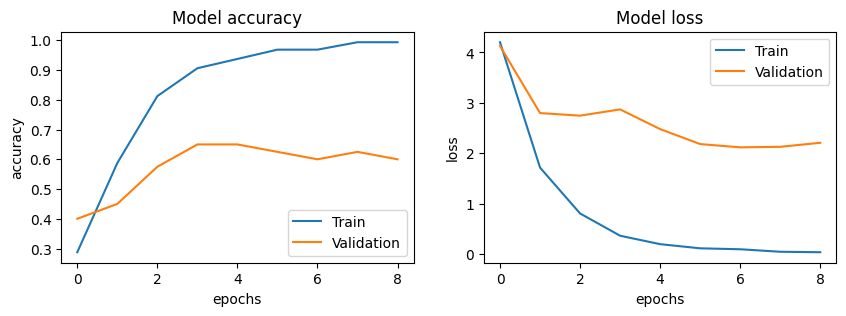

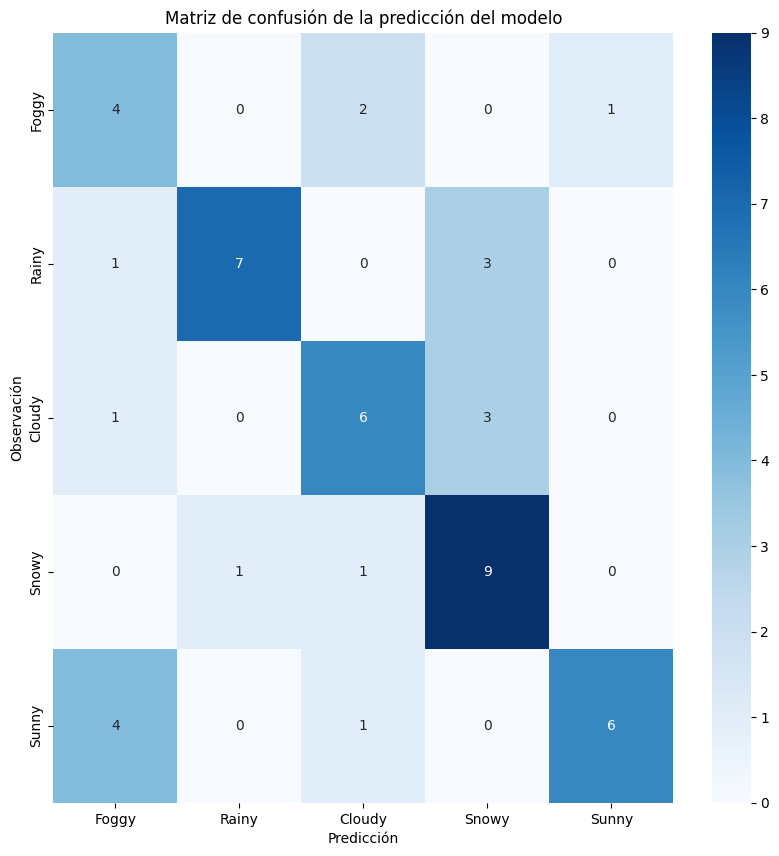

    Test Loss: 1.65754
Test Accuracy: 64.00%


In [17]:
numero_epocas=100

VGG19_pre=preprocess_input

train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = generacion_de_datos(VGG19_pre,train_df,test_df)

VGG19_model, callback=crear_modelo(VGG19)

history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=numero_epocas,
    callbacks=callback,
    verbose=0
)
history_VGG19= graficar(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

evaluar_modelo(test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = resultado_test(test_gen_VGG19,VGG19_model)

##MobileNet

In [18]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

Found 160 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.


2/2 [==============================] - 1s 136ms/step
              precision    recall  f1-score   support

      Cloudy       0.36      0.57      0.44         7
       Foggy       0.91      0.91      0.91        11
       Rainy       0.60      0.60      0.60        10
       Snowy       0.67      0.73      0.70        11
       Sunny       0.83      0.45      0.59        11

    accuracy                           0.66        50
   macro avg       0.67      0.65      0.65        50
weighted avg       0.70      0.66      0.66        50



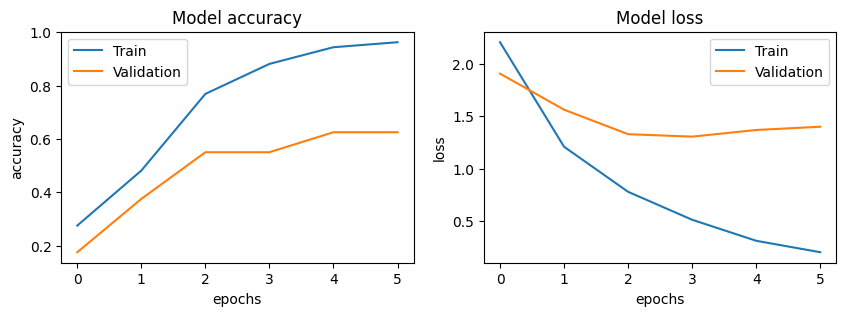

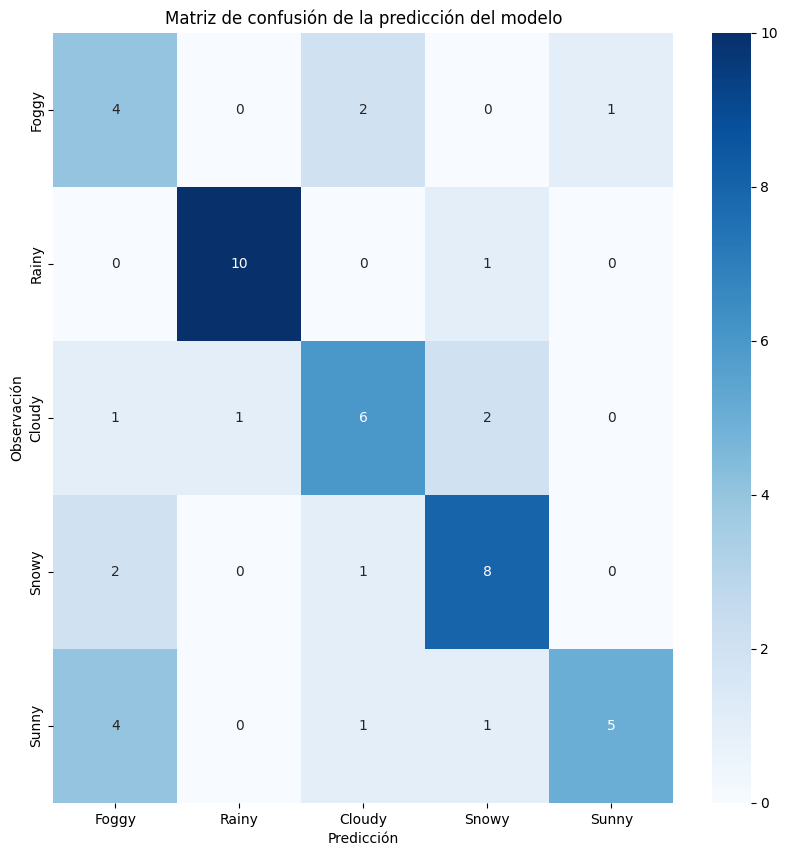

    Test Loss: 0.97579
Test Accuracy: 66.00%


In [19]:
MobileNet_pre=preprocess_input

train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = generacion_de_datos(MobileNet_pre,train_df,test_df)

MobileNet_model, callback=crear_modelo(MobileNet)

history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)

history_MobileNet = graficar(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

evaluar_modelo(test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = resultado_test(test_gen_MobileNet,MobileNet_model)

##Resnet101

In [20]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

Found 160 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
171446536/171446536 [==============================] - 2s 0us/step


2/2 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

      Cloudy       0.67      0.86      0.75         7
       Foggy       1.00      1.00      1.00        11
       Rainy       0.78      0.70      0.74        10
       Snowy       0.79      1.00      0.88        11
       Sunny       1.00      0.64      0.78        11

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.83        50
weighted avg       0.86      0.84      0.84        50



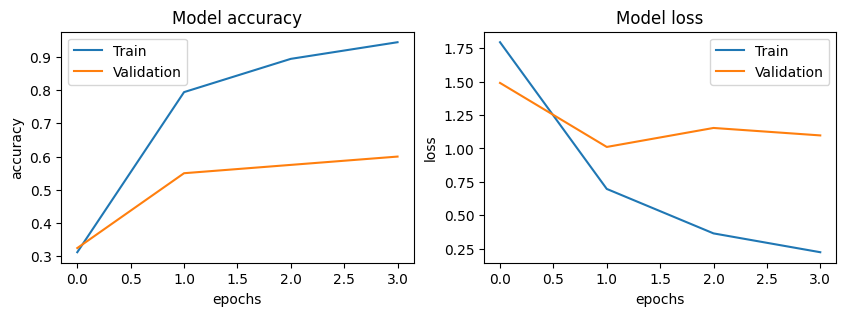

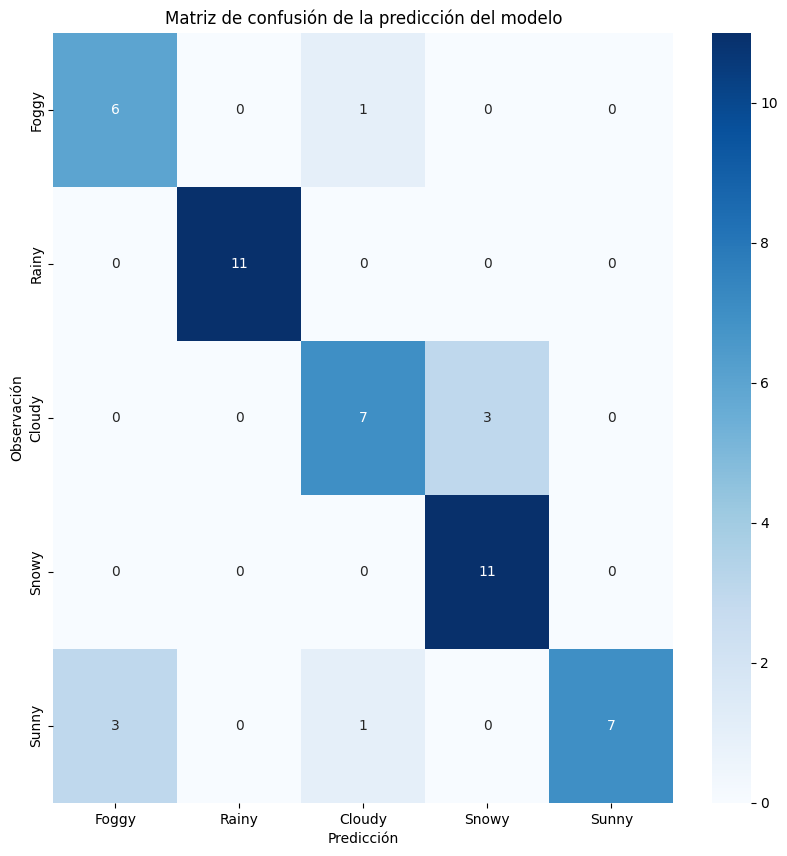

    Test Loss: 0.55185
Test Accuracy: 84.00%


In [21]:
numero_epocas=100

ResNet101_pre=preprocess_input

train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = generacion_de_datos(ResNet101_pre,train_df,test_df)

model_ResNet101, callback = crear_modelo(ResNet101)

history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)

history = graficar(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)

evaluar_modelo(test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)

result_ResNet101 = resultado_test(test_gen_ResNet101,model_ResNet101)

##DenseNet201

In [22]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

Found 160 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
74836368/74836368 [==============================] - 0s 0us/step


2/2 [==============================] - 7s 748ms/step
              precision    recall  f1-score   support

      Cloudy       0.50      0.71      0.59         7
       Foggy       0.92      1.00      0.96        11
       Rainy       0.86      0.60      0.71        10
       Snowy       0.90      0.82      0.86        11
       Sunny       0.73      0.73      0.73        11

    accuracy                           0.78        50
   macro avg       0.78      0.77      0.77        50
weighted avg       0.80      0.78      0.78        50



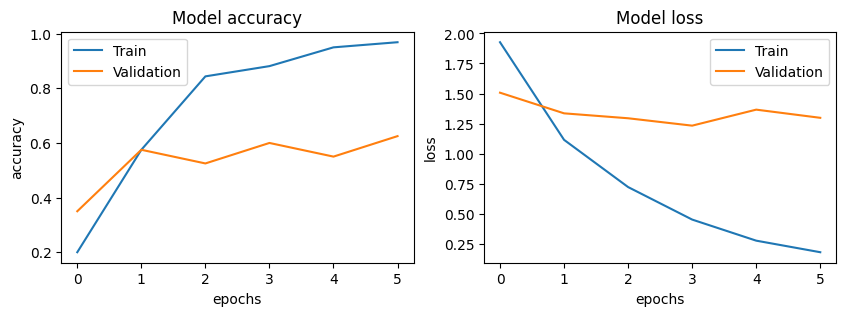

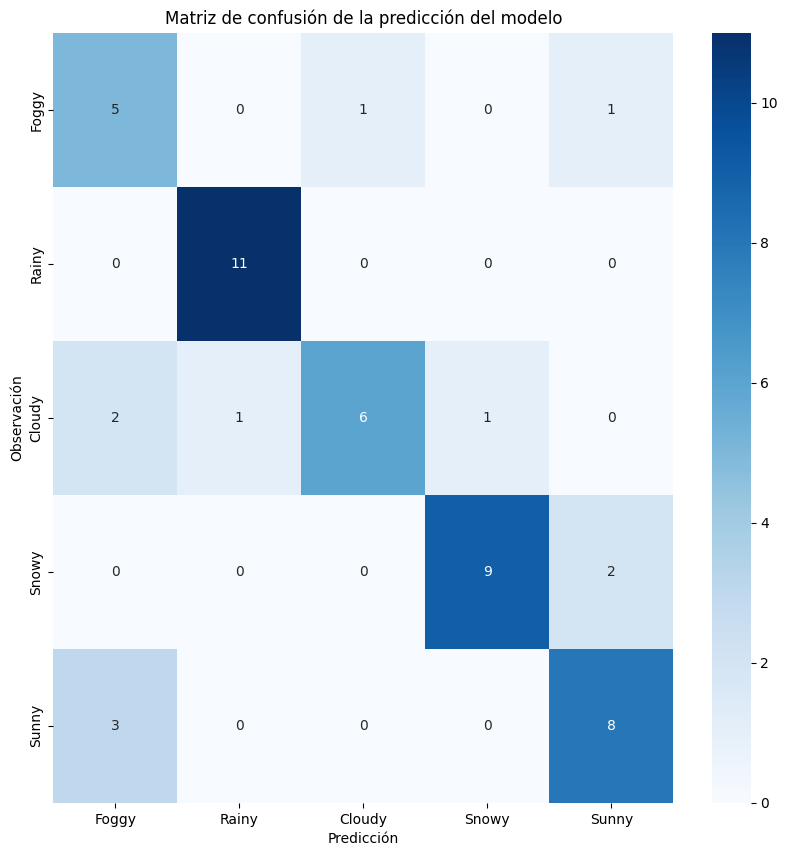

    Test Loss: 0.55127
Test Accuracy: 78.00%


In [23]:
DenseNet201_pre=preprocess_input

train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = generacion_de_datos(DenseNet201_pre,train_df,test_df)

model_DenseNet201, callback=crear_modelo(DenseNet201)

history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=graficar(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)

evaluar_modelo(test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)

result_DenseNet201 = resultado_test(test_gen_DenseNet201,model_DenseNet201)

#Comparación entre modelos

In [24]:
output = pd.DataFrame({'Model':['ResNet50','MobileNet','VGG19','ResNet101','DenseNet201'],'Accuracy':[result_ResNet[1], result_MobileNet[1], result_VGG19[1],result_ResNet101[1],result_DenseNet201[1]]})

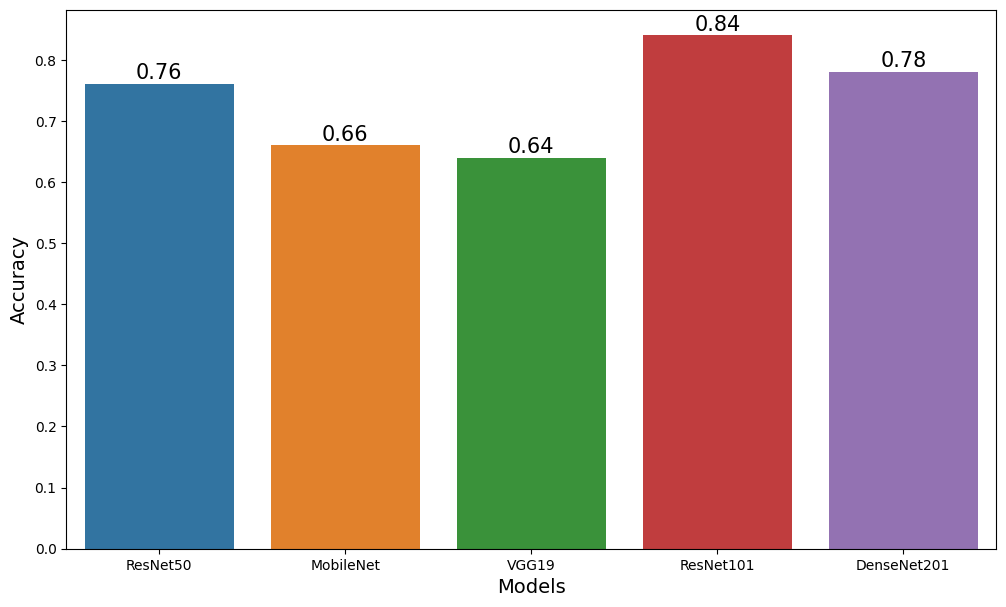

In [25]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()